In [1]:
from example import spark

:: loading settings :: url = jar:file:/Users/da/.pyenv/versions/3.8.10/envs/rikai-example/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/da/.ivy2/cache
The jars for the packages stored in: /Users/da/.ivy2/jars
ai.eto#rikai_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-017fac17-a32c-4edb-99fc-01df71acbed4;1.0
	confs: [default]
	found ai.eto#rikai_2.12;0.0.12 in central
	found org.antlr#antlr4-runtime;4.8-1 in local-m2-cache
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.apache.logging.log4j#log4j-api-scala_2.12;12.0 in central
	found org.scala-lang#scala-reflect;2.12.10 in spark-list
	found org.apache.logging.log4j#log4j-api;2.13.2 in central
	found io.circe#circe-core_2.12;0.12.3 in central
	found io.circe#circe-numbers_2.12;0.12.3 in central
	found org.typelevel#cats-core_2.12;2.0.0 in central
	found org.typelevel#cats-macros_2.12;2.0.0 in central
	found org.typelevel#cats-kernel_2.12;2.0.0 in central
	found io.circe#circe-generic_2.12;0.12.3 in central
	found com.chuusai#shapeless_2.12;2.3.3 in spark-list
	found org.typ

In [2]:
df = spark.read.format("parquet").load("/tmp/rikai_example/elephants_dream")
df.createOrReplaceTempView("elephants_dream")

In [3]:
mlflow_tracking_uri = "sqlite:///mlruns.db"
registered_model_name = f"yolov5s-model"

spark.conf.set("rikai.sql.ml.registry.mlflow.tracking_uri", mlflow_tracking_uri)

spark.sql(f"""
    CREATE OR REPLACE MODEL mlflow_yolov5_m
    POSTPROCESSOR 'transform.yolov5.post_processing'
    USING 'mlflow:///{registered_model_name}';
""")

2021-11-17 13:16:29,822 INFO Rikai (mlflow_registry.py:223): Resolving model mlflow_yolov5_m from mlflow:///yolov5s-model
2021-11-17 13:16:30,480 INFO Rikai (base.py:207): Created model inference pandas_udf with name mlflow_yolov5_m_14c0b18b


DataFrame[]

In [4]:
from rikai.spark.functions.vision import to_image
spark.udf.register("to_image", to_image)

<function rikai.spark.functions.vision.to_image(image_data: Union[bytes, bytearray, str, pathlib.Path]) -> rikai.types.vision.Image>

In [5]:
result = spark.sql("""
from (
  select 
    frame_id,
    date_format(ts, 'mm:ss') as progress,
    image_data
  from elephants_dream
  where frame_id > 1000 and frame_id < 1100
)
select
  frame_id,
  progress,
  to_image(image_data) as image,
  ML_PREDICT(mlflow_yolov5_m, image_data) as pred
limit 10
""").collect()

In [6]:
result[0]

Row(frame_id=1016, progress='00:42', image=Image(<embedded>), pred=Row(boxes=[[489.0, 94.0, 575.0, 294.0], [110.0, 306.0, 231.0, 371.0]], scores=[0.8199999928474426, 0.4399999976158142], label_ids=[0, 0]))

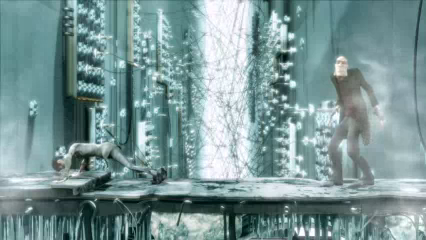

In [7]:
result[0].image